# Projeto de Final de PDI

## Detecção do Transtorno do Espectro Autista (TEA) por Imagem

Instalando nilearn para treinamennto e leitura utilizando fMRI's e importando o banco de dados de dentro do Bucket da AWS e extraindo para uma pasta dentro da máquina virtual com as especificações de derivativas e estratégias

In [ ]:
!pip install nilearn

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
from nilearn import plotting
import nibabel as nib
import glob
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

##Teste de acurácia com derivativa DPARSF e pipeline ReHO

Explicar aqui como funciona a utilização de Derivativas, pipelines e estratégias e o que elas implicam no processamento e na utilização de filtros de frequência (passa-faixa e passa-baixas)

Tamanho do dataset
pacientes com TEA: 236
Neurotípicos de controle: 236
total: 572

In [ ]:
#Fazendo o download de dados de homens com TEA - Derivativa: ReHo e Estratégia: filter_noglobal
!python download_abide_preproc.py -d reho -p dparsf -s filt_noglobal -o /content/data_male/asd/ -lt 18 -gt 5 -x 'M' --asd

#Fazendo o download de dados de homens neurotípicos (Typical control or tdc)  - Derivativa: ReHo e Estratégia: filter_noglobal
!python download_abide_preproc.py -d reho -p dparsf -s filt_noglobal -o /content/data_male/tdc/ -lt 18 -gt 5 -x 'M' --tdc

In [ ]:
#Fazendo o download de dados de homens com TEA - Derivativa: VMHC e Estratégia: filter_noglobal
!python download_abide_preproc.py -d vmhc -p dparsf -s filt_noglobal -o /content/data_male/asd/ -lt 18 -gt 5 -x 'M' --asd

#Fazendo o download de dados de homens neurotípicos (Typical control or tdc)  - Derivativa: VMHC e Estratégia: filter_noglobal
!python download_abide_preproc.py -d vmhc -p dparsf -s filt_noglobal -o /content/data_male/tdc/ -lt 18 -gt 5 -x 'M' --tdc

In [ ]:
dataset_asd = np.empty([236,61,73,61] , dtype=np.float64)
counter = 0
#Carregar arquivos de pacientes com  Can not squeeze dim[1], expected a dimension of 1, got 73 for '{{node Squeeze}} = Squeeze[T=DT_INT64, squeeze_dims=[-1]](ArgMax)' with input shapes: [?,73].TEA
for filename in glob.glob('/content/data_male/asd/Outputs/dparsf/filt_noglobal/reho/*.nii.gz', recursive=True):
    img_data =  nib.load(filename).get_fdata()
    #img = img_data[:, :, img_data.shape[2] // 2].T
    dataset_asd[counter, :, :, :] = img_data[:, :, :]
    counter +=1

#print(counter)


In [ ]:
print(img_data.shape)

(61, 73, 61)


In [ ]:
dataset_tdc = np.empty([236,61,73,61] , dtype=np.float64)
counter = 0
#Carregar arquivos de pacientes neurotípicos de controle e excluindo os últimos arquivos para que o tamanho do dataset_tdc seja igual ao dataset_asd
for filename in glob.glob('/content/data_male/tdc/Outputs/dparsf/filt_noglobal/reho/*.nii.gz', recursive=True)[:236]:
    img_data =  nib.load(filename).get_fdata()
    #img = img_data[:, :, img_data.shape[2] // 2].T
    dataset_tdc[counter, :, :, :] = img_data[:, :, :]
    counter +=1

print(counter)


236


In [ ]:
print(dataset_tdc.shape)
print(dataset_asd.shape)
#putting the two datasets together in a pattern of 4 are asd and 4 are tdc and so on...
#dataset_reho = np.empty([472, 73, 61], dtype=np.float64)
dataset_reho = np.concatenate((dataset_asd, dataset_tdc), axis=0)
print(dataset_reho.shape)

(236, 61, 73, 61)
(236, 61, 73, 61)
(472, 61, 73, 61)


In [ ]:
#Creating labels asd and tdc (1 for 'has autism' 0 for 'does not have autism')
labels = np.empty(dataset_reho.shape[0], dtype='<U6')
labels[:235] = 'asd'
labels[236:] = 'tdc'


In [ ]:
#Separa os dados e começa a preparação para oo treinamento da rede neural
# Create list of indices and shuffle them
N = dataset_reho.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = dataset_reho[indices_train, ...]
X_test = dataset_reho[indices_test, ...]

print(X_train.shape, X_test.shape)


(377, 61, 73, 61) (95, 61, 73, 61)


In [ ]:
y_train = labels[indices_train] == 'asd'
y_test = labels[indices_test] == 'asd'


In [ ]:
print(y_train)
print(y_train.shape)

[False  True False False  True False False  True False  True  True False
  True False False False  True  True  True  True  True False False  True
  True  True False False  True False  True False  True  True  True  True
  True False False  True  True  True False False  True  True  True False
 False False False  True  True False  True False  True  True  True False
 False False False  True  True  True False False False False  True  True
 False  True  True False False  True  True False  True  True  True  True
 False False  True False False False False  True False False  True False
  True  True  True False False False  True False  True  True False False
 False False  True False False False False  True False False  True False
 False False  True  True  True  True False False False False  True  True
 False  True False False  True False  True  True  True False  True False
 False  True False False False  True  True False False False False False
  True False  True False False False  True False  T

In [ ]:
#Data Scalling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
pca = PCA()
tsne = TSNE()

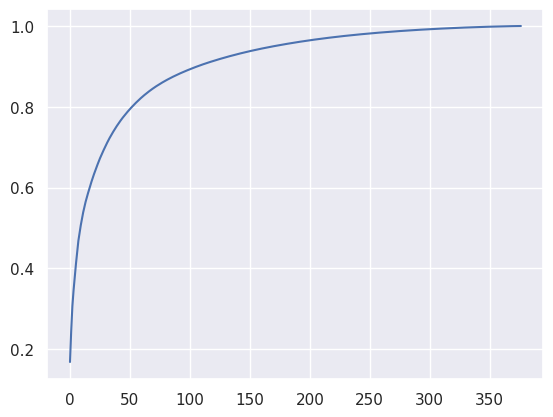

In [ ]:
X_scaled = scaler.fit_transform(X_train.reshape(len(X_train), -1))
X_pca = pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_.cumsum())

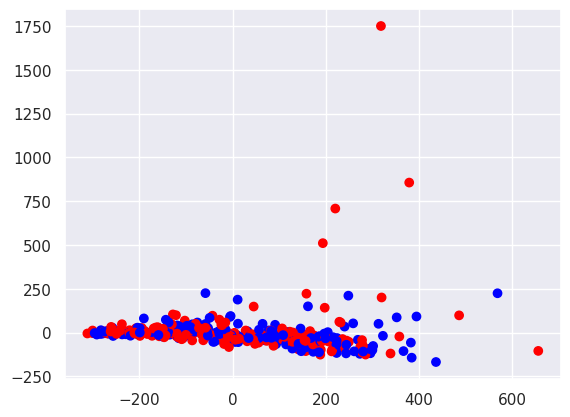

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='bwr')

In [ ]:
X_tsne = tsne.fit_transform(X_pca)

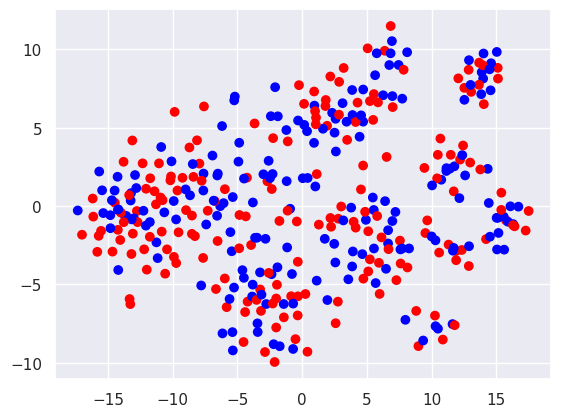

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='bwr')

In [ ]:
mean = X_train.mean(axis=0)
mean.shape
std = X_train.std(axis=0)
std.shape

(61, 73, 61)

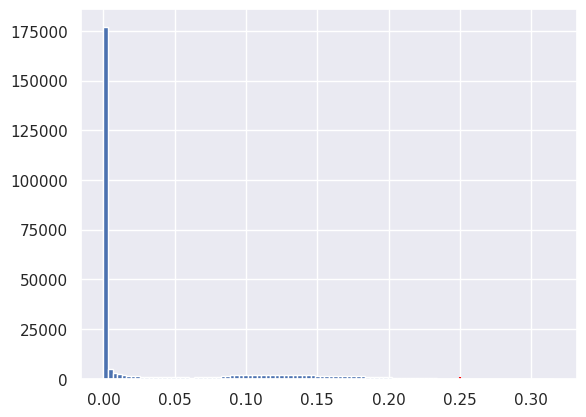

In [ ]:
std[std<0.05] = 0
plt.hist(np.ravel(mean), bins=100);
plt.vlines(0.25, 0, 1000, colors='red')

In [ ]:
mean[mean<0.05] = 0
mask = (mean*std)!=0
X_zscore_tr = (X_train-mean)/std
X_zscore_te = (X_test-mean)/std
X_zscore_tr.shape

<ipython-input-167-09c4a041fa6f>:3: RuntimeWarning: divide by zero encountered in divide
  X_zscore_tr = (X_train-mean)/std
<ipython-input-167-09c4a041fa6f>:3: RuntimeWarning: invalid value encountered in divide
  X_zscore_tr = (X_train-mean)/std
<ipython-input-167-09c4a041fa6f>:4: RuntimeWarning: divide by zero encountered in divide
  X_zscore_te = (X_test-mean)/std
<ipython-input-167-09c4a041fa6f>:4: RuntimeWarning: invalid value encountered in divide
  X_zscore_te = (X_test-mean)/std


(377, 61, 73, 61)

In [ ]:
X_zscore_tr[np.isnan(X_zscore_tr)]=0
X_zscore_te[np.isnan(X_zscore_te)]=0
X_zscore_tr[np.isinf(X_zscore_tr)]=0
X_zscore_te[np.isinf(X_zscore_te)]=0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf

In [ ]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

In [ ]:
# Specify number of filters per layer
filters = 32

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', # swap out for sgd
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 59, 71, 32)        17600     
                                                                 
 batch_normalization_29 (Ba  (None, 59, 71, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 29, 35, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 27, 33, 64)        18496     
                                                                 
 batch_normalization_30 (Ba  (None, 27, 33, 64)        256       
 tchNormalization)                                               
                                                     

In [ ]:
nEpochs = 125  # Increase this value for better results (i.e., more training) #125 foi o valor utilizado no teste

In [ ]:
batch_size = 32   # Increasing this value might speed up fitting

In [ ]:
%time fit = model.fit(X_zscore_tr, y_train, epochs=nEpochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/125
10/10 [==============================] - 18s 2s/step - loss: 1.3187 - accuracy: 0.4850 - val_loss: 0.7619 - val_accuracy: 0.4342
Epoch 2/125
10/10 [==============================] - 8s 778ms/step - loss: 1.2188 - accuracy: 0.5249 - val_loss: 0.9339 - val_accuracy: 0.5263
Epoch 3/125
10/10 [==============================] - 9s 940ms/step - loss: 1.1243 - accuracy: 0.4917 - val_loss: 1.0298 - val_accuracy: 0.5263
Epoch 4/125
10/10 [==============================] - 9s 965ms/step - loss: 1.0173 - accuracy: 0.5382 - val_loss: 1.2937 - val_accuracy: 0.5789
Epoch 5/125
10/10 [==============================] - 9s 934ms/step - loss: 0.9869 - accuracy: 0.5681 - val_loss: 0.9217 - val_accuracy: 0.5395
Epoch 6/125
10/10 [==============================] - 9s 837ms/step - loss: 0.9546 - accuracy: 0.5648 - val_loss: 0.9175 - val_accuracy: 0.4605
Epoch 7/125
10/10 [==============================] - 9s 911ms/step - loss: 1.0202 - accuracy: 0.5349 - val_loss: 0.8826 - val_accuracy: 0.3553
E

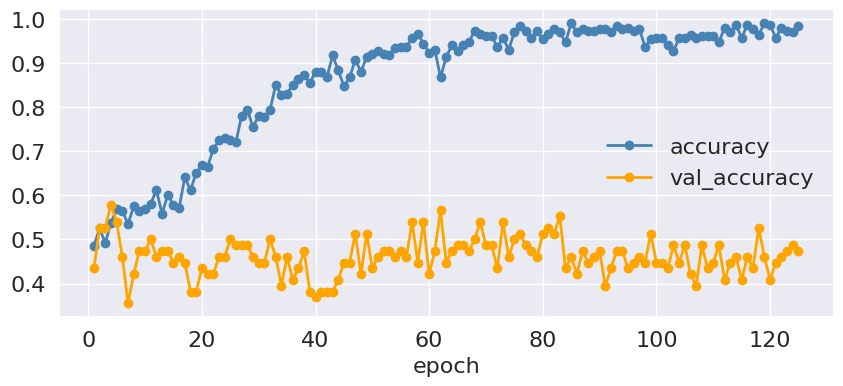

In [ ]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

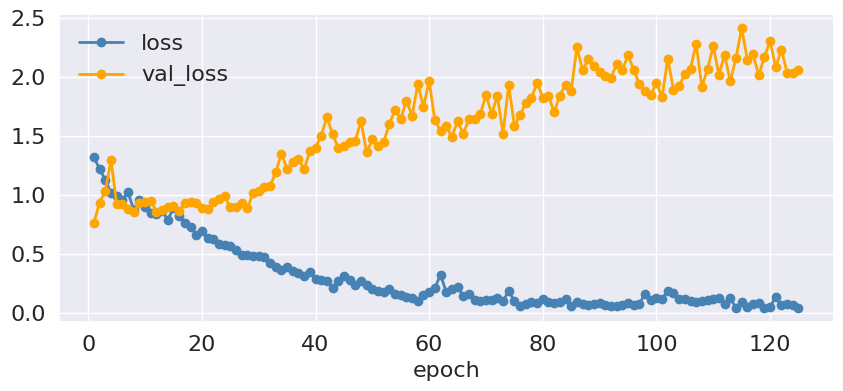

In [ ]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="steelblue", label="loss")
plt.plot(epoch, fit.history['val_loss'], marker="o", linewidth=2,
         color="orange", label="val_loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

3/3 [==============================] - 1s 165ms/step - loss: 9.6822 - accuracy: 0.4947
Loss in Test set:      9.68
Accuracy in Test set:  49.47


(61, 73, 61)


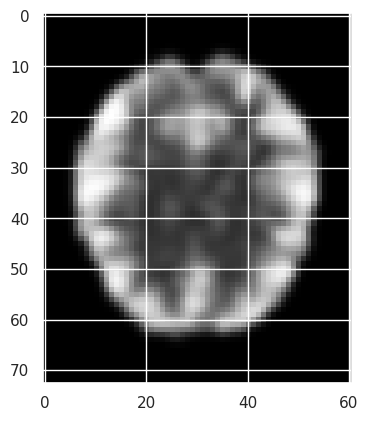

In [ ]:
t1 = nib.load('/content/data_male/asd/Outputs/dparsf/filt_noglobal/reho/Caltech_0051472_reho.nii.gz')
data = t1.get_fdata()
plt.imshow(data[:, :, data.shape[2] // 2].T, cmap='Greys_r')
print(data.shape)

##Teste de acurácia utilizando agora a derivativa DPARSF e a pipeline VMHC

In [ ]:
dataset_asd_vmhc = np.empty([236,61,73,61] , dtype=np.float64)
counter = 0
#Carregar arquivos de pacientes com  Can not squeeze dim[1], expected a dimension of 1, got 73 for '{{node Squeeze}} = Squeeze[T=DT_INT64, squeeze_dims=[-1]](ArgMax)' with input shapes: [?,73].TEA
for filename in glob.glob('/content/data_male/asd/Outputs/dparsf/filt_noglobal/vmhc/*.nii.gz', recursive=True):
    img_data =  nib.load(filename).get_fdata()
    #img = img_data[:, :, img_data.shape[2] // 2].T
    dataset_asd_vmhc[counter, :, :, :] = img_data[:, :, :]
    counter +=1

print(counter)


236


In [ ]:
dataset_tdc_vmhc = np.empty([236,61,73,61] , dtype=np.float64)
counter = 0
#Carregar arquivos de pacientes neurotípicos de controle e excluindo os últimos arquivos para que o tamanho do dataset_tdc seja igual ao dataset_asd
for filename in glob.glob('/content/data_male/tdc/Outputs/dparsf/filt_noglobal/vmhc/*.nii.gz', recursive=True)[:236]:
    img_data =  nib.load(filename).get_fdata()
    #img = img_data[:, :, img_data.shape[2] // 2].T
    dataset_tdc_vmhc[counter, :, :, :] = img_data[:, :, :]
    counter +=1

print(counter)


236


In [ ]:
print(dataset_tdc_vmhc.shape)
print(dataset_asd_vmhc.shape)
#putting the two datasets together in a pattern of 4 are asd and 4 are tdc and so on...
#dataset_reho = np.empty([472, 73, 61], dtype=np.float64)
dataset_vmhc = np.concatenate((dataset_asd_vmhc, dataset_tdc_vmhc), axis=0)
print(dataset_vmhc.shape)

(236, 61, 73, 61)
(236, 61, 73, 61)
(472, 61, 73, 61)


In [ ]:
#Creating labels asd and tdc (1 for 'has autism' 0 for 'does not have autism')
labels = np.empty(dataset_vmhc.shape[0], dtype='<U6')
labels[:235] = 'asd'
labels[236:] = 'tdc'


In [ ]:
#Separa os dados e começa a preparação para oo treinamento da rede neural
# Create list of indices and shuffle them
N = dataset_vmhc.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = dataset_vmhc[indices_train, ...]
X_test = dataset_vmhc[indices_test, ...]

print(X_train.shape, X_test.shape)


(377, 61, 73, 61) (95, 61, 73, 61)


In [ ]:
y_train = labels[indices_train] == 'asd'
y_test = labels[indices_test] == 'asd'
print(y_train)
print(y_train.shape)

[False  True  True  True False False False False False False  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False False False  True  True  True  True  True False False  True False
  True False  True  True False False False  True False False False  True
  True False False  True  True False False False  True  True  True  True
 False  True  True False  True  True  True  True  True  True False  True
 False  True  True False  True  True  True False  True False  True False
 False  True  True  True  True False  True  True  True False False  True
 False  True  True  True  True  True False  True False False False  True
  True False False  True  True  True False False  True False  True False
  True  True  True False False  True False  True  True  True False  True
  True  True False  True  True False  True False False  True  True  True
 False False False False  True False  True  True  True  True False False
  True False False  True False False  True  True Fa

In [ ]:
scaler = StandardScaler()
pca = PCA()
tsne = TSNE()

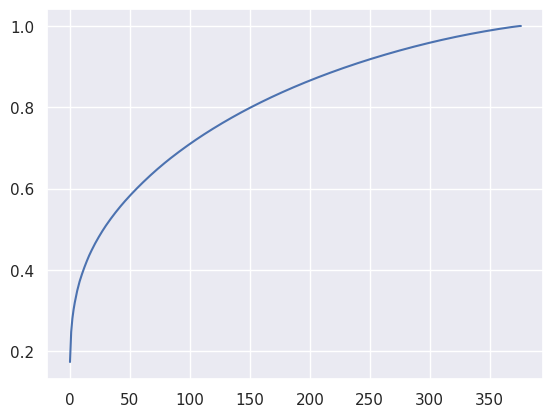

In [ ]:
X_scaled = scaler.fit_transform(X_train.reshape(len(X_train), -1))
X_pca = pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_.cumsum())

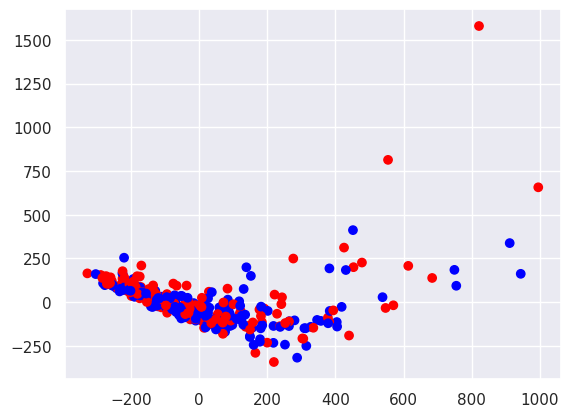

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='bwr')

In [ ]:
X_tsne = tsne.fit_transform(X_pca)

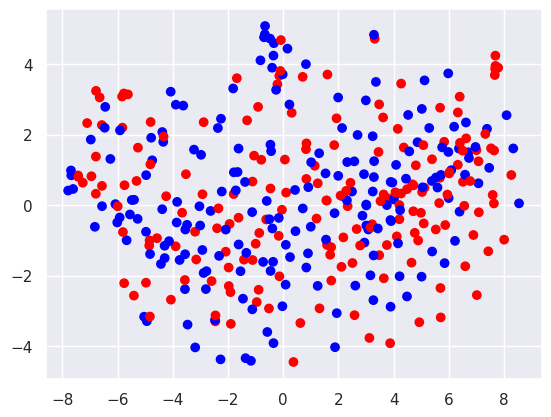

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='bwr')

In [ ]:
mean = X_train.mean(axis=0)
mean.shape
std = X_train.std(axis=0)
std.shape

(61, 73, 61)

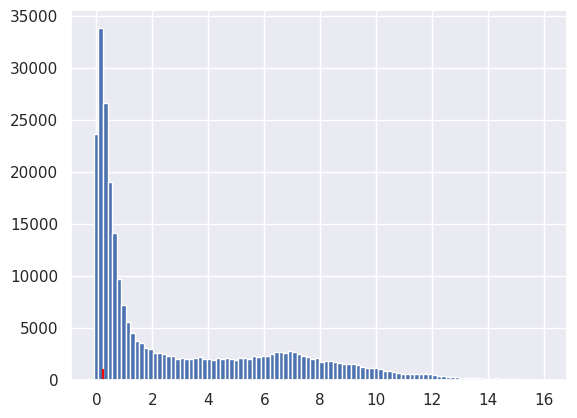

In [ ]:
std[std<0.05] = 0
plt.hist(np.ravel(mean), bins=100);
plt.vlines(0.25, 0, 1000, colors='red')

In [ ]:
mean[mean<0.05] = 0
mask = (mean*std)!=0
X_zscore_tr = (X_train-mean)/std
X_zscore_te = (X_test-mean)/std
X_zscore_tr.shape

(377, 61, 73, 61)

In [ ]:
X_zscore_tr[np.isnan(X_zscore_tr)]=0
X_zscore_te[np.isnan(X_zscore_te)]=0
X_zscore_tr[np.isinf(X_zscore_tr)]=0
X_zscore_te[np.isinf(X_zscore_te)]=0

In [ ]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

In [ ]:
# Specify number of filters per layer
filters = 32

model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Conv2D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
filters *= 2

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', # swap out for sgd
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 59, 71, 32)        17600     
                                                                 
 batch_normalization_35 (Ba  (None, 59, 71, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 29, 35, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 27, 33, 64)        18496     
                                                                 
 batch_normalization_36 (Ba  (None, 27, 33, 64)        256       
 tchNormalization)                                               
                                                     

In [ ]:
nEpochs = 125  # Increase this value for better results (i.e., more training)
batch_size = 32   # Increasing this value might speed up fitting

In [ ]:
%time fit = model.fit(X_zscore_tr, y_train, epochs=nEpochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/125
10/10 [==============================] - 13s 882ms/step - loss: 1.3053 - accuracy: 0.4784 - val_loss: 1.2121 - val_accuracy: 0.5132
Epoch 2/125
10/10 [==============================] - 10s 983ms/step - loss: 1.0819 - accuracy: 0.5980 - val_loss: 1.7930 - val_accuracy: 0.5132
Epoch 3/125
10/10 [==============================] - 9s 875ms/step - loss: 0.9943 - accuracy: 0.5748 - val_loss: 2.1745 - val_accuracy: 0.5132
Epoch 4/125
10/10 [==============================] - 8s 772ms/step - loss: 1.0147 - accuracy: 0.5880 - val_loss: 1.7132 - val_accuracy: 0.5263
Epoch 5/125
10/10 [==============================] - 9s 891ms/step - loss: 0.9225 - accuracy: 0.5880 - val_loss: 1.7249 - val_accuracy: 0.5395
Epoch 6/125
10/10 [==============================] - 9s 877ms/step - loss: 0.8138 - accuracy: 0.6478 - val_loss: 1.3771 - val_accuracy: 0.5263
Epoch 7/125
10/10 [==============================] - 8s 804ms/step - loss: 0.8665 - accuracy: 0.6279 - val_loss: 1.0943 - val_accuracy: 0.56

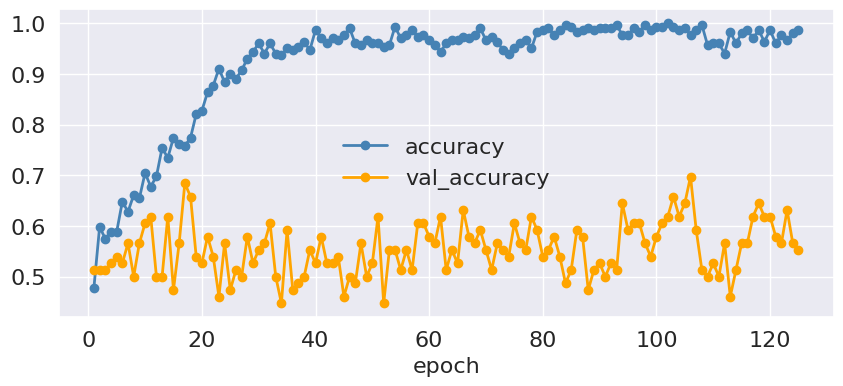

In [ ]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

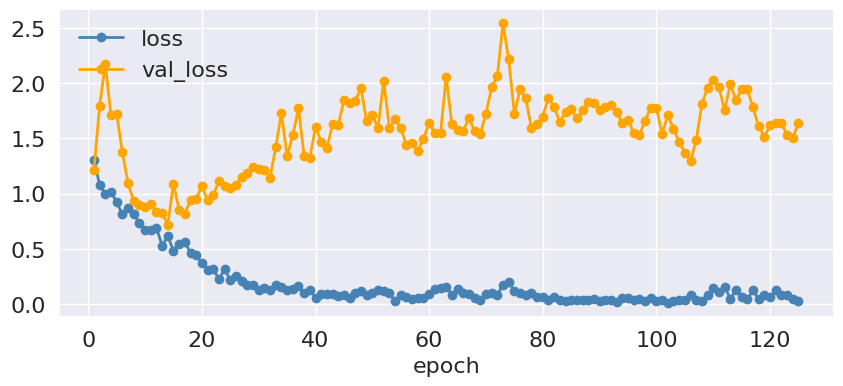

In [ ]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="steelblue", label="loss")
plt.plot(epoch, fit.history['val_loss'], marker="o", linewidth=2,
         color="orange", label="val_loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

3/3 [==============================] - 1s 182ms/step - loss: 6.7236 - accuracy: 0.4632
Loss in Test set:      6.72
Accuracy in Test set:  46.32
